In [1]:
import os
os.environ['OMP_NUM_THREADS']='3'

from IPython.display import clear_output

import numpy as np
import matplotlib.pyplot as plt

from reaktoro_transport.mesh import XDMFMesh, MarkedRectangleMesh
from reaktoro_transport.problem import StokesFlowUzawa

from dolfin import *

%matplotlib inline
plt.rcParams.update({'font.size': 18})

In [2]:
class MeshFactory(XDMFMesh, MarkedRectangleMesh):
    def __init__(self):
        super().__init__()
        
    def generate_boundary_markers(self, boundary_eps=1e-8):
        self.boundary_markers = MeshFunction('size_t', self.mesh,
                                             dim=self.mesh.geometric_dimension()-1)

        self.boundary_markers.set_all(0)
        
        all_marker = self.AllBoundary()
        right_marker = self.RightBoundary(self.xmax, boundary_eps)
        top_marker = self.TopBoundary(self.ymax, boundary_eps)
        left_marker = self.LeftBoundary(self.xmin, boundary_eps)
        bottom_marker = self.BottomBoundary(self.ymin, boundary_eps)

        # This index is resevered for all the not explicitly marked cells
        all_marker.mark(self.boundary_markers, 555)

        right_marker.mark(self.boundary_markers, 1)
        top_marker.mark(self.boundary_markers, 2)
        left_marker.mark(self.boundary_markers, 3)
        bottom_marker.mark(self.boundary_markers, 4)

        marker_dict = {'right': 1, 'top': 2, 'left': 3, 'bottom': 4}

        return self.boundary_markers, marker_dict

    def get_mesh_and_markers(self):
        try:
            self.read_mesh('../01_mesh_generation/pore_mesh.xdmf')
        except:
            raise Exception('filepath does not contain mesh.')

        self.set_bottom_left_coordinates(coord_x = 0.0, coord_y = 0.0)
        self.set_top_right_coordinates(coord_x = 5.0, coord_y = 5.0)
        
        #self.refine_mesh()
        self.boundary_markers, self.marker_dict = self.generate_boundary_markers()
        domain_markers = self.generate_domain_markers()

        return self.mesh, self.boundary_markers, domain_markers

    def refine_mesh(self):
        cell_markers = MeshFunction('bool', self.mesh, dim=self.mesh.geometric_dimension())
        cell_markers.set_all(1)
        
        self.mesh = refine(self.mesh, cell_markers)

In [3]:
factory = MeshFactory()
mesh, boundary_markers, domain_markers = factory.get_mesh_and_markers()

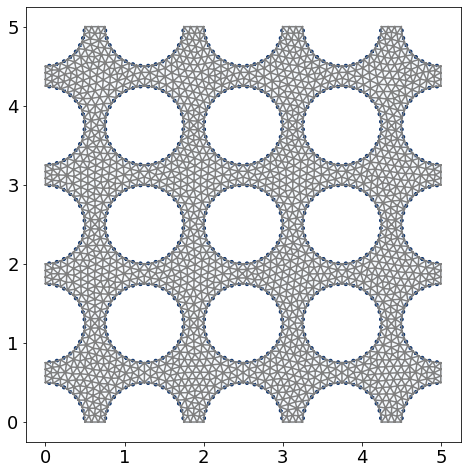

In [4]:
# Plot mesh
fig, ax = plt.subplots(1, 1, figsize=(8,8))
plot(mesh)
factory.plot_boundary_markers(ax, s=10)
plt.show()

In [5]:
flow_problem = StokesFlowUzawa(mesh, boundary_markers, domain_markers)

In [6]:
# Defining the inlet and noslip boundary markers
b_dict = {'inlet': [2, 4], 'noslip': [1, 3, 555], 'velocity_bc': []}
flow_problem.mark_flow_boundary(**b_dict)

In [7]:
flow_problem.set_velocity_vector_fe_space('CR', 1)
flow_problem.set_pressure_fe_space('DG', 0)

flow_problem.set_pressure_ic(Expression('0.0', degree=0))

flow_problem.set_fluid_density(1.0)
flow_problem.set_fluid_viscosity(1.0)
flow_problem.set_gravity((0.0, 0.0))

p_dirichlet_list = [Constant(1.0), Constant(0.0)]
flow_problem.set_pressure_bc(p_dirichlet_list)
flow_problem.generate_form()
flow_problem.set_velocity_bc(velocity_bc_val=[])

flow_problem.set_additional_parameters(r_val=3e3, omega_by_r=1.0)
flow_problem.assemble_matrix()
flow_problem.set_flow_solver_params()

In [8]:
%%time 
velocity, pressure = flow_problem.solve_flow(target_residual=1e-10, max_steps=20)

clear_output()

  1 KSP preconditioned resid norm 5.362554433388e-12 true resid norm 5.362554516186e-12 ||r(i)||/||b|| 4.202309590459e-11
  2 KSP preconditioned resid norm 8.934907247694e-13 true resid norm 8.934905440674e-13 ||r(i)||/||b|| 7.001744916505e-12
  3 KSP preconditioned resid norm 1.575544006589e-13 true resid norm 1.575545786322e-13 ||r(i)||/||b|| 1.234659927108e-12
  4 KSP preconditioned resid norm 3.051459296854e-14 true resid norm 3.051458295321e-14 ||r(i)||/||b|| 2.391243281650e-13
Stokes flow residual = 3.2140451393723064e-10
  0 KSP preconditioned resid norm 2.271440978641e-11 true resid norm 2.271440978641e-11 ||r(i)||/||b|| 1.779990894346e-10
  1 KSP preconditioned resid norm 2.493677845945e-12 true resid norm 2.493677901959e-12 ||r(i)||/||b|| 1.954144527927e-11
  2 KSP preconditioned resid norm 4.150389583231e-13 true resid norm 4.150389800614e-13 ||r(i)||/||b|| 3.252409427561e-12
  3 KSP preconditioned resid norm 7.318468619501e-14 true resid norm 7.318482417678e-14 ||r(i)||/||b

In [9]:
# Check residual
flow_problem.get_flow_residual()

1.4994358424852272e-10

In [10]:
length = 5.0
pressure_gradient = 1.0/length
surface_area = 5.0

flow_rate = flow_problem.get_flow_rate(factory.marker_dict['bottom']) # Length^3 / time
permeability = flow_rate/surface_area/pressure_gradient

print(flow_rate, permeability)
print(length**2/12) # theoretical permeability of a fracture

0.003682681400317756 0.003682681400317756
2.0833333333333335


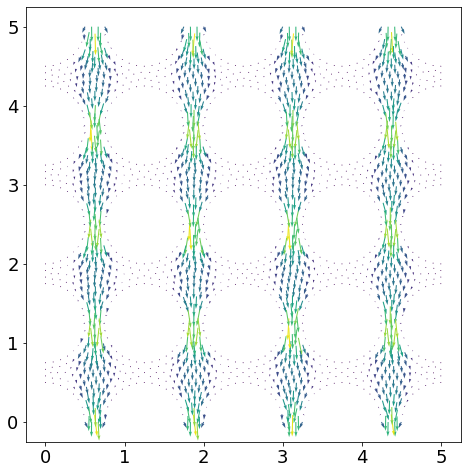

In [11]:
fig = plt.figure(figsize=(13,8))
#cb = plot(pressure)
plot(velocity)
#fig.colorbar(cb)
plt.show()